In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from PIL import Image

import keras
import keras.backend as K
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import plot_model, to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint

import time
import os

import pickle



/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# CNN Design

Here, I'll create a couple different variants of the classic LeNet CNN archetecture for the purpose of the EMNIST digit classification problem. 

I'll also include image purturbation and data augmentations methods, such as random rotations and shear. 

## 0. Load Data:


In [2]:
# training set
with open("../data/preproccessed/basic/X_train.npy", "rb") as handle:
    X = np.load(handle)

In [3]:
# test set
with open("../data/preproccessed/basic/X_test.npy", "rb") as handle:
    X_test = np.load(handle)

In [4]:
# Training labels
# training set
with open("../data/preproccessed/basic/y_train.npy", "rb") as handle:
    y = np.load(handle)

In [5]:
# sanity check - shapes ok? 
print(X.shape)
print(y.shape)
print(X_test.shape)

(50000, 28, 28)
(50000, 1)
(10000, 28, 28)


Label: 7


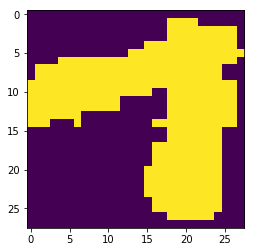

In [6]:
# Did the data get currupted?
plt.imshow(X[1])
print("Label: %d" % y[1])

## 1. Creating training/validation splits

This should be done consistently. Throughout this project (across all classifiers), we will use the random state `1`. 

We will use an 80:20 split for the training:validation split. 

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [8]:
# sanity check - shapes look ok? 
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(40000, 28, 28)
(10000, 28, 28)
(40000, 1)
(10000, 1)


## 2. Reshape images (to be 3d)

Convnets take in 3D images as input, with the third dimension being the channels. 

Since we're working with Black and white images (no channels), we can artifically create this second third dimension by setting a depth of one for each image. 

The way we reshape the image depends on our `Keras` settings. From the docs:

```
The ordering of the dimensions in the inputs. `channels_last` corresponds to inputs with shape (batch, height, width, channels) while `channels_first` corresponds to inputs with shape (batch, channels, height, width). It defaults to the image_data_format value found in your Keras config file at `~/.keras/keras.json`. If you never set it, then it will be "channels_last".
```

In [9]:
# reshape the ouput vectors, so that they're vectors (not column matrices)
y_train = y_train.reshape((y_train.shape[0],))
y_valid = y_valid.reshape((y_valid.shape[0],))

In [10]:
X_test.shape


(10000, 28, 28)

In [11]:
# isolate training, validation and testing shapes, currently
trainshape, validshape, testshape = X_train.shape, X_valid.shape, X_test.shape
# Reshape the X's, according to our channel setting. 
if K.image_data_format() == "channels_last":
    X_train = X_train.reshape((trainshape[0],trainshape[1],trainshape[2], 1))
    X_valid = X_valid.reshape((validshape[0],validshape[1],validshape[2], 1))
    X_test = X_test.reshape((testshape[0],testshape[1],testshape[2], 1))
else:
    X_train = X_train.reshape((trainshape[0],1,trainshape[1],trainshape[2]))
    X_valid = X_valid.reshape((validshape[0],1,validshape[1],validshape[2]))
    X_test = X_test.reshape((testshape[0],1,testshape[1],testshape[2]))

In [12]:
K.image_data_format()

'channels_last'

In [13]:
# sanity check - shapes look ok? 
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)

(40000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(40000,)
(10000,)


## 3. Several CNN architectures

Here, I'll create several CNN archetectures, of varying depths. 

In [14]:
def model_3conv(height, width, depth, stride = 3, pool_size = 2):
    """
    CNN Keras model with 3 convolutions.
    
    parameters:
        - height: Shape of each image
        - stride: stride size
        
    return: 
        - A Keras `Sequential` model with an RMS-prop optimizer.
    """
    # set the input shape
    if K.image_data_format() == "channels_first":
        input_shape = (depth, height, width)
    else:
        input_shape = (height,width,depth)
            
    model = Sequential()
    model.add(Conv2D(8, (stride, stride), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(8, (stride, stride)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(16, (stride, stride), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    return model, opt

In [15]:
def model_4conv(height, width, depth, stride = 3, pool_size = 2):
    """
    CNN Keras model with 4 convolutions.
    
    parameters:
        - height,width,depth: Shape of each image
        - stride: stride size
        
    return: 
        - A Keras `Sequential` model with an RMS-prop optimizer.
    """
    # set the input shape
    if K.image_data_format() == "channels_first":
        input_shape = (depth, height, width)
    else:
        input_shape = (height,width,depth)
            
    model = Sequential()
    model.add(Conv2D(8, (stride, stride), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(8, (stride, stride)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(16, (stride, stride), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(16, (stride, stride), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    return model, opt

In [16]:
def model_4conv2(height, width, depth, stride = 5, pool_size = 2):
    """
    Another CNN Keras model with 4 convolutions. 
    This one, however, emphasizes dimensionality reduction through larger stride length, 
    and fewer pooling layers
    
    parameters:
        - height,width,depth: Shape of each image
        - stride: stride size
        
    return: 
        - A Keras `Sequential` model with an RMS-prop optimizer.
    """
    # set the input shape
    if K.image_data_format() == "channels_first":
        input_shape = (depth, height, width)
    else:
        input_shape = (height,width,depth)
            
    model = Sequential()
    model.add(Conv2D(8, (stride, stride), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(8, (stride, stride)))
    model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
#     model.add(Dropout(0.25))
    
    model.add(Conv2D(16, (stride, stride), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(16, (stride, stride), padding='same'))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    return model, opt

In [39]:
def model_6conv(height, width, depth, stride = 3, pool_size = 2):
    """
    CNN Keras model with 6 convolutions.
    
    parameters:
        - height,width,depth: Shape of each image
        - stride: stride size
        
    return: 
        - A Keras `Sequential` model with an RMS-prop optimizer.
    """
    # set the input shape
    if K.image_data_format() == "channels_first":
        input_shape = (depth, height, width)
    else:
        input_shape = (height,width,depth)
            
    model = Sequential()
    model.add(Conv2D(8, (stride, stride), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(8, (stride, stride)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(16, (stride, stride), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(16, (stride, stride), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, (stride, stride), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (stride, stride), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    return model, opt

## 4. Image augmentation

The EMNIST dataset was created by taking the MNIST dataset, and applying a series of random rotations and zooms. 

By extracting the largest digit from each image, each of our images should be the same size. They are, however, rotate. 

To account for this, we will augment our original dataset by applying a series of random rotations/shears to each digit. This will help increase the robustness to distortions, and should help combat overfitting. 

In [18]:
# construct the image generator for data augmentation
img_gen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)

We must fit the generator to our data


In [19]:
img_gen.fit(X_train)

For example, take the following digit:

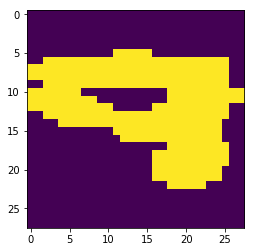

In [20]:
plt.imshow(X_train[0].reshape((28,28)))

Here, we I create 21 purturpations of this original image

In [21]:
# a function for stiching a bunch of square images together
def gallery(array, ncols=3):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols)
    result = (array.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result

In [22]:
distorted = np.empty(shape = (0,28,28), dtype = "uint8")
i = 0
for batch in img_gen.flow(X_train[[0]], batch_size=1,):
    i += 1
    pd
    distorted = np.append(distorted, batch.reshape((28,28)).astype("uint8"))
    if i > 20:
        break
distorted = distorted.reshape((21,28,28))

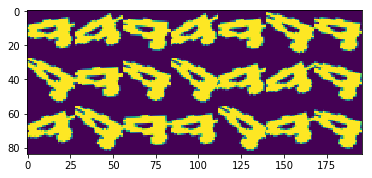

In [23]:
plt.imshow(gallery(distorted, ncols = 7))

From one image, we get 21, which are different enough that we can learn new interesting features from them. 

## 5. Prepare for training:

First, with our simplest model - three convolutional layers. Initializing this model

In [24]:
model, opt = model_3conv(height = 28, width = 28, depth = 1)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 8)         584       
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        1168      
__________

In [26]:
# compile the model
model.compile(loss='categorical_crossentropy',
                      optimizer= opt,
                      metrics=['accuracy'])

In [27]:
plot_model(model, "images/baseline.png")

![](images/baseline.png)

Currently, the labels are ingegers. We need functions to convert them to/from one-hot encodings

In [28]:
# train an encoder to convert labels to integer labels, one-hot encodings, and back
encoder = LabelEncoder().fit(y.reshape((y.shape[0],)))

def encode_onehot(lab):
    return to_categorical(encoder.transform(lab))

def decode_onehot(lab):
    return encoder.inverse_transform(np.argmax(lab, axis = 1))

Finally, I'll create checkpoints to allow for early stopping, and saving of the best model. 

In [37]:
if not os.path.isdir("models"):
    os.makedirs("models")

In [43]:
filepath="models/weights_3conv_%s.hdf5" % time.strftime("%d%m%Y")

In [44]:
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode="max")
# create an Early Stopping callback
early_stopping = EarlyStopping(patience=15)

## 6. Train!

In [6]:
# fit the model, and save the output
history = model.fit_generator(img_gen.flow(X_train, encode_onehot(y_train), batch_size=10),
        validation_data=(X_valid, encode_onehot(y_valid)), steps_per_epoch=len(X_train),
        epochs=1, verbose=1, callbacks = [early_stopping, checkpointer])

In [64]:
historyname = "history_3conv_%s" % time.strftime("%h%d_%H%S")

In [62]:
if not os.path.isdir("history"):
    os.makedirs("history")

In [66]:
with open(historyname, "wb") as handle:
    pickle.dump(history.history, handle, protocol = 3)

In [3]:
a = time.time()
time.time() -a

3.4809112548828125e-05